In [54]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from PIL import Image

from sklearn.model_selection import train_test_split
import tensorflow as tf

c:\users\kok gin xian\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Determine image pairs

In [124]:
image_pairs = []

for root, dirs, files in os.walk("datasets/NIND"):
#     print(root, len(files))
    
    if len(files) > 0:
#         print(files)
        
        label = [f for f in files if "ISO100." in f]
#         print("label:", label)
        
        if len(label) == 0:
            label = [f for f in files if "ISO200." in f]
            
        assert len(label) == 1
        
        others = list(set(files) - set(label))
#         print("others:", others)
        
        for f in others:
            image_pairs.append((os.path.join(root, f), os.path.join(root, label[0])))

In [125]:
len(image_pairs)

513

In [126]:
image_pairs[np.random.randint(0, len(image_pairs))]

('datasets/NIND\\ursulines-red\\NIND_ursulines-red_ISOH1.jpg',
 'datasets/NIND\\ursulines-red\\NIND_ursulines-red_ISO200.jpg')

In [127]:
df_image_pairs = pd.DataFrame(
    image_pairs,
    columns=["input_image", "label_image"]
)

In [128]:
df_image_pairs.head()

,input_image,label_image
0,datasets/NIND\banana\NIND_banana_ISOH2.png,datasets/NIND\banana\NIND_banana_ISO200.png
1,datasets/NIND\banana\NIND_banana_ISO250.png,datasets/NIND\banana\NIND_banana_ISO200.png
2,datasets/NIND\banana\NIND_banana_ISO2000.png,datasets/NIND\banana\NIND_banana_ISO200.png
3,datasets/NIND\banana\NIND_banana_ISO800.png,datasets/NIND\banana\NIND_banana_ISO200.png
4,datasets/NIND\banana\NIND_banana_ISO4000.png,datasets/NIND\banana\NIND_banana_ISO200.png


## Train test split

In [129]:
noisy_images_train, noisy_images_test, clean_images_train, clean_images_test = train_test_split(df_image_pairs["input_image"], df_image_pairs["label_image"], test_size=0.1)

In [130]:
len(noisy_images_train), len(noisy_images_test), len(clean_images_train), len(clean_images_test)

(461, 52, 461, 52)

## Image resizing

In [56]:
def fit_image_to_size(img, target_width, target_height, resize=False):
    """
    Fit an image to a target width and height, with the option of whether or not to
    resize the source image to the target width and height while maintaining its aspect ratio.
    
    Args:
        img: The image to be fitted to the target width and height in np.ndarray format.
        target_width: The target width of the resized image.
        target_height: The target height of the resized image.
        resize: Whether to resize image to fit to target width and height.
        
    Returns:
        A new image of target width and height with the source image fitted into it.
    """
    
    assert isinstance(img, np.ndarray), "Image must be of type np.ndarray."
    assert len(img.shape) == 3, "Can only accept 3 dimensional image."

    assert target_width >= 1, "Invalid target width: {}".format(target_width)
    assert target_height >= 1, "Invalid target height: {}".format(target_height)
    
    if img.shape[2] == 4:
        img = skimage.color.rgba2rgb(img, background=(255, 255, 255))
        
    assert img.shape[2] == 3, "Number of channels in image must be 3, got: {}".format(img.shape[2])

    canvas = np.zeros(
        shape=(int(target_height), int(target_width), img.shape[2]), 
        dtype=np.float32
    )
#     print("canvas.shape:", canvas.shape)

#     print("img.shape:", img.shape)
#     print("img:", img)

    if resize:
        src_img_width = img.shape[1]
        src_img_height = img.shape[0]

        width_ratio = target_width / src_img_width
        height_ratio = target_height / src_img_height
#         print("width_ratio:", width_ratio)
#         print("height_ratio:", height_ratio)
        ratio = min(width_ratio, height_ratio)

        img_resized = skimage.transform.resize(
            img, (int(ratio * src_img_height), int(ratio * src_img_width))
        )
#         print("img_resized.shape:", img_resized.shape)
    else:
        if np.issubdtype(img.dtype, np.unsignedinteger):
            img_resized = img / np.float32(255)
        else:
            img_resized = img

    img_resized = img_resized.astype(np.float32)

    # Paste (resized or original) image on canvas
    size_dim_0 = min(img_resized.shape[0], canvas.shape[0])
    size_dim_1 = min(img_resized.shape[1], canvas.shape[1])
    size_dim_2 = min(img_resized.shape[2], canvas.shape[2])
    
    canvas[
        : size_dim_0,
        : size_dim_1,
        : size_dim_2
    ] = img_resized[
        : size_dim_0,
        : size_dim_1,
        : size_dim_2
    ]
    return canvas

In [62]:
def resize_image_pair(img1_paths, img2_paths, img1_base_dir, img2_base_dir, target_width, target_height, resize=True):
    for p1, p2, in zip(img1_paths, img2_paths):
        if os.path.isfile(os.path.join(img1_base_dir, os.path.basename(p1))) and os.path.isfile(os.path.join(img2_base_dir, os.path.basename(p2))):
            continue
        
        img1 = skimage.io.imread(p1)
        img2 = skimage.io.imread(p2)
        
        img1_resized = fit_image_to_size(img1, target_width=target_width, target_height=target_height, resize=resize)
        img2_resized = fit_image_to_size(img2, target_width=target_width, target_height=target_height, resize=resize)
        
        os.makedirs(img1_base_dir, exist_ok=True)
        os.makedirs(img2_base_dir, exist_ok=True)
        
        skimage.io.imsave(os.path.join(img1_base_dir, os.path.basename(p1)), img1_resized)
        skimage.io.imsave(os.path.join(img2_base_dir, os.path.basename(p2)), img2_resized)

In [159]:
%%time

resize_image_pair(img1_paths=noisy_images_test, 
                  img2_paths=clean_images_test, 
                  img1_base_dir="NIND-1920x1080/test/noisy/",
                  img2_base_dir="NIND-1920x1080/test/clean/",
                  target_width=1920, target_height=1080,
                  resize=True)

W0705 20:12:18.878018 16340 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0705 20:12:19.062739 16340 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0705 20:12:20.919607 16340 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0705 20:12:21.110186 16340 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0705 20:12:24.828233 16340 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0705 20:12:25.009794 16340 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0705 20:12:28.841490 16340 util.py:64] Lossy 

W0705 20:15:18.810295 16340 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0705 20:15:20.777665 16340 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0705 20:15:28.948693 16340 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0705 20:15:29.170669 16340 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0705 20:15:32.343254 16340 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0705 20:15:32.584536 16340 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0705 20:15:38.703528 16340 util.py:64] Lossy 

Wall time: 5min 34s


## Create TFRecord files from images

In [31]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [32]:
def serialize_image_pair_example2(input_image_path, label_image_path):
    """
    Creates a tf.Example message ready to be written to a file.
    """

    # Create a dictionary mapping the feature name to the tf.Example-compatible
    # data type.

    input_image = np.array(Image.open(input_image_path))
    label_image = np.array(Image.open(label_image_path))

    with open(input_image_path, "rb") as f:
        input_image_str = f.read()
    with open(label_image_path, "rb") as f:
        label_image_str = f.read()

    feature = {
        "input_image/filename": _bytes_feature(
            tf.compat.as_bytes(os.path.basename(input_image_path))
        ),
        "input_image/width": _int64_feature(input_image.shape[1]),
        "input_image/height": _int64_feature(input_image.shape[0]),
        "input_image/channels": _int64_feature(3),
        "input_image/raw": _bytes_feature(input_image_str),
        
        "label_image/filename": _bytes_feature(
            tf.compat.as_bytes(os.path.basename(label_image_path))
        ),
        "label_image/width": _int64_feature(label_image.shape[1]),
        "label_image/height": _int64_feature(label_image.shape[0]),
        "label_image/channels": _int64_feature(3), # XXX WATCH OUT FOR DEPTH
        "label_image/raw": _bytes_feature(label_image_str),
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))

    return example_proto.SerializeToString()

In [33]:
def create_image_pair_tfrecords(path, input_images, label_images):
    with tf.python_io.TFRecordWriter(path) as writer:
        count = 0

        for input_image_path, label_image_path in zip(input_images, label_images):
            example = serialize_image_pair_example2(input_image_path, label_image_path)
            writer.write(example)
            count += 1

            if count % 10 == 0:
                print(count)

    print("Done!")

In [162]:
%%time 

# create_image_pair_tfrecords("train-nind.tfrecords", noisy_images_train, clean_images_train)

create_image_pair_tfrecords("train-nind-1920x1080.tfrecords", 
                                  [os.path.join("NIND-1920x1080/train/noisy/", os.path.basename(f)) for f in noisy_images_train], 
                                  [os.path.join("NIND-1920x1080/train/clean/", os.path.basename(f)) for f in clean_images_train])

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
Done!
Wall time: 53.8 s


In [163]:
%%time 

# create_image_pair_tfrecords("val-nind.tfrecords", noisy_images_test, clean_images_test)

create_image_pair_tfrecords("val-nind-1920x1080.tfrecords", 
                                  [os.path.join("NIND-1920x1080/test/noisy/", os.path.basename(f)) for f in noisy_images_test], 
                                  [os.path.join("NIND-1920x1080/test/clean/", os.path.basename(f)) for f in clean_images_test])

10
20
30
40
50
Done!
Wall time: 7.27 s


## TFRecord files validation

In [45]:
def parse_image_pair_example2(example_proto):
    # Create a dictionary describing the features.
    dataset_feature_description = {
        "input_image/filename": tf.FixedLenFeature([], tf.string),
        "input_image/width": tf.FixedLenFeature([], tf.int64),
        "input_image/height": tf.FixedLenFeature([], tf.int64),
        "input_image/channels": tf.FixedLenFeature([], tf.int64),
        "input_image/raw": tf.FixedLenFeature([], tf.string),
        
        "label_image/filename": tf.FixedLenFeature([], tf.string),
        "label_image/width": tf.FixedLenFeature([], tf.int64),
        "label_image/height": tf.FixedLenFeature([], tf.int64),
        "label_image/channels": tf.FixedLenFeature([], tf.int64),
        "label_image/raw": tf.FixedLenFeature([], tf.string),
    }

    # Parse the input tf.Example proto using the dictionary above.
    example = tf.parse_single_example(example_proto, dataset_feature_description)

    input_image = tf.image.decode_image(example["input_image/raw"], 3, dtype=tf.float32)
    label_image = tf.image.decode_image(example["label_image/raw"], 3, dtype=tf.float32) # XXX WATCH OUT FOR DEPTH
    
    return input_image, label_image

In [46]:
plt.rcParams['figure.figsize'] = 15, 8

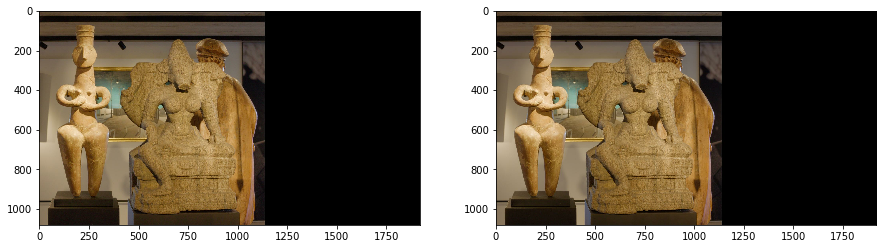

In [189]:
# Validate that our input pipeline works

dataset = tf.data.TFRecordDataset(["val-nind-1920x1080.tfrecords"])
dataset = dataset.map(parse_image_pair_example2).shuffle(20).batch(1)
iterator = dataset.make_one_shot_iterator()
input_images_tensor, label_images_tensor = iterator.get_next()

with tf.Session() as sess:
    test_input_images, test_label_images = sess.run(
        [input_images_tensor, label_images_tensor]
    )

    fig = plt.figure()

    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(test_input_images[0])

    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(np.squeeze(test_label_images[0]))